# Plot Cosmosis Chains

In [1]:
pwd

'/Users/arwa.q/Desktop/bf_plots'

In [58]:
import pandas as pd

def read_cosmosis_chain(filename):
    header = []
    # Read only the header line
    with open(filename, 'r') as f:
        for line in f:
            if not line.startswith('#'):
                break
            else:
                header.append(line)
    raw_names = header[0].strip('#').strip().split('\t')
    clean_names = [name.split('--')[-1] for name in raw_names]

    # Load the actual data
    df = pd.read_csv(filename, comment='#', delim_whitespace=True, header=None)
    df.columns = clean_names
    return df

# Usage
#chain_file = '/Users/esteves/Downloads/test_per_bin00.txt'
chain_file = '/Users/arwa.q/Desktop/bf_plots/pr2_l0z0.txt'
#chain_file = '/Users/arwa.q/Desktop/bf_plots/pr2_l3z0.txt'
#chain_file = '/Users/arwa.q/Desktop/bf_plots/test_per_binc20.txt'
df = read_cosmosis_chain(chain_file)

/var/folders/95/7hnb49ms3217pvkx_6925mr40000gn/T/ipykernel_11941/4076165680.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filename, comment='#', delim_whitespace=True, header=None)


In [2]:
# df = df.drop(columns='prior')
df

,logrs_00,logb0_00,prior,post
0,0.003955,-0.000682,-1.386294,-86747.963086
1,0.002754,-0.000339,-1.386294,-86498.963799
2,-0.003503,0.000295,-1.386294,-84731.973437
3,-0.003613,0.003594,-1.386294,-86068.006063
4,0.000965,0.004002,-1.386294,-87749.594437
...,...,...,...,...
199995,-0.559029,-0.687064,-1.386294,-14.316608
199996,-0.622828,-0.597196,-1.386294,-14.822999
199997,-0.540497,-0.710709,-1.386294,-14.860710
199998,-0.563170,-0.680629,-1.386294,-14.204307


In [50]:
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
import numpy as np

def plot_corner_getdist(df, param_labels=None, name_tag='chain', sigma_clip=3, external_means=None):
    """
    Generate a corner plot from a CosmoSIS DataFrame using GetDist.
    - Converts 'log' parameters to linear scale.
    - Clips each parameter to +/- N sigma.
    
    Parameters:
    - df: pandas DataFrame with samples, may contain a 'post' column.
    - param_labels: Optional list of LaTeX-style labels.
    - name_tag: Optional string to tag the chain.
    - sigma_clip: Number of standard deviations for clipping (default: 5σ).

    Returns:
    - fig: The matplotlib figure object.
    """
    # Drop 'prior' column if it exists
    df_params = df.drop(columns=['prior','post']) if 'prior' in df.columns else df.copy()

    # Drop rows with NaN or inf
    df_params = df_params.replace([np.inf, -np.inf], np.nan).dropna()

    # Convert log columns to linear and rename
    clean_names = []
    for col in df_params.columns:
        if col.startswith('log'):
            df_params[col] = 10**df_params[col]
            clean_names.append(col[3:])  # remove 'log'
        else:
            clean_names.append(col)
    df_params.columns = clean_names

    # 5-sigma clipping
    for col in df_params.columns:
        mu = df_params[col].mean()
        sigma = df_params[col].std()
        df_params = df_params[(df_params[col] > mu - sigma_clip * sigma) &
                              (df_params[col] < mu + sigma_clip * sigma)]

    # Parameter labels
    labels = param_labels if param_labels is not None else clean_names
    truths = [external_means.get(name, (None,))[0] for name in clean_names]
    print(truths)
    # GetDist MCSamples
    samples = MCSamples(samples=df_params.values,
                        names=clean_names,
                        labels=labels,
                        name_tag=name_tag)

    # Plot
    g = plots.getSubplotPlotter()
    g.triangle_plot([samples], filled=True, truths=truths, truth_color='r')
    # For each parameter, add a vertical reference line at the external mean
    for pname, (mean, sigma) in external_means.items():
        if mean is not None and pname in clean_names:
            # Get the axis for the 1D marginal of this parameter
            ax = g.subplots[clean_names.index(pname), clean_names.index(pname)]
            ax.axvline(mean, color='k', linestyle='--', linewidth=1.5)
            # Optional: add ±1σ shading
            ax.axvspan(mean - sigma, mean + sigma, color='gray', alpha=0.2)
    return g.fig


In [11]:
pip install getdist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.8/830.8 kB 5.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.30.0 requires packaging<24,>=16.8, but you have packaging 25.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


[None, None]
Removed no burn in


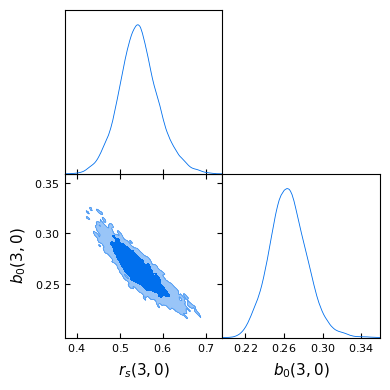

In [55]:
labels = [r"r_s (3,0) ", r"b_0 (3,0)"]
#external_means = {'rs_00': (0.80, 0.15), 'b0_00': (0.27, 0.05)}
#external_means = {'rs_00': (0.44, 0.06), 'b0_00': (0.34, 0.05)}#l0z0
external_means = {'rs_00': (1.37, 0.21), 'b0_00': (0.23, 0.03)}
fig = plot_corner_getdist(df, param_labels=labels, external_means=external_means)
plt.show()

In [25]:
print(df.columns.tolist()) 
df_clean = df.drop(columns=['prior', 'post'], errors='ignore')
df_clean = df_clean.replace([np.inf, -np.inf], np.nan).dropna()
print(len(df_clean))


['logrs_00', 'logb0_00', 'prior', 'post']
50000


In [27]:
external_means = {
    'logrs_00': (0.44, 0.06),
    'logb0_00': (0.34, 0.05)
}


In [30]:
from getdist import plots, MCSamples
import numpy as np
import matplotlib.pyplot as plt

# Clean chain
df_clean = df.drop(columns=['prior', 'post'], errors='ignore')
df_clean = df_clean.replace([np.inf, -np.inf], np.nan).dropna()

# Prepare samples
samples = MCSamples(samples=df_clean.values, names=df_clean.columns.tolist(), labels=df_clean.columns.tolist())
samples.updateSettings({'smooth_scale_2D': 0.6, 'fine_bins_2D': 200})

# External means
external_means = {
    'logrs_00': (0.44, 0.06),
    'logb0_00': (0.34, 0.05)
}

# Set up plotter
g = plots.getSubplotPlotter()

# Truth values
truths = [external_means.get(name, (None,))[0] for name in df_clean.columns]

# Plot
g.triangle_plot([samples], filled=True, truths=truths, truth_color='r')

plt.show()



Removed no burn in


In [29]:
import getdist
print(getdist.__version__)


1.6.5


In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trace(df, burnin=0.0, external_means=None):
    """
    Plot trace plots with:
    - Horizontal lines at sample mean (red dashed)
    - Optional reference values from other work (black dashed)

    Parameters:
    - df: pandas DataFrame with samples, may include 'post'.
    - burnin: fraction of samples to discard.
    - external_means: dict of {param_name: (mean, sigma)} in linear scale.

    Returns:
    - fig: matplotlib figure.
    """
    # Drop 'post' column and clean
    df_params = df.drop(columns='prior') if 'prior' in df.columns else df.copy()
    df_params = df_params.replace([np.inf, -np.inf], np.nan).dropna()

    # Convert log columns to linear
    trace_df = df_params.copy()
    new_names = []
    for col in trace_df.columns:
        if col.startswith("log"):
            trace_df[col] = 10**trace_df[col]
            new_names.append(col[3:])
        else:
            new_names.append(col)
    trace_df.columns = new_names

    # Apply burn-in
    if burnin > 0.0:
        n = int(len(trace_df) * burnin)
        trace_df = trace_df.iloc[n:]

    # Plot setup
    n_params = len(trace_df.columns)
    fig, axes = plt.subplots(n_params, 1, figsize=(10, 2.5 * n_params), sharex=True)
    if n_params == 1:
        axes = [axes]

    for i, col in enumerate(trace_df.columns):
        data = trace_df[col].values
        sample_mean = data.mean()

        axes[i].plot(data, lw=0.7, alpha=0.8)
        axes[i].axhline(sample_mean, color='r', linestyle='--', label=f'sample mean = {sample_mean:.3g}')

        if external_means and col in external_means:
            ref_mean, ref_sigma = external_means[col]
            axes[i].axhline(ref_mean, color='k', linestyle='--', label=f'ref = {ref_mean:.2f}')
            axes[i].fill_between(
                np.arange(len(data)),
                ref_mean - ref_sigma,
                ref_mean + ref_sigma,
                color='gray',
                alpha=0.2,
                label='±1σ ref'
            )

        axes[i].set_ylabel(col)
        axes[i].legend()
        axes[i].grid(True)

    axes[-1].set_xlabel("Sample index")
    fig.suptitle("Trace Plots with Sample Mean and External Reference", fontsize=15)
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    return fig


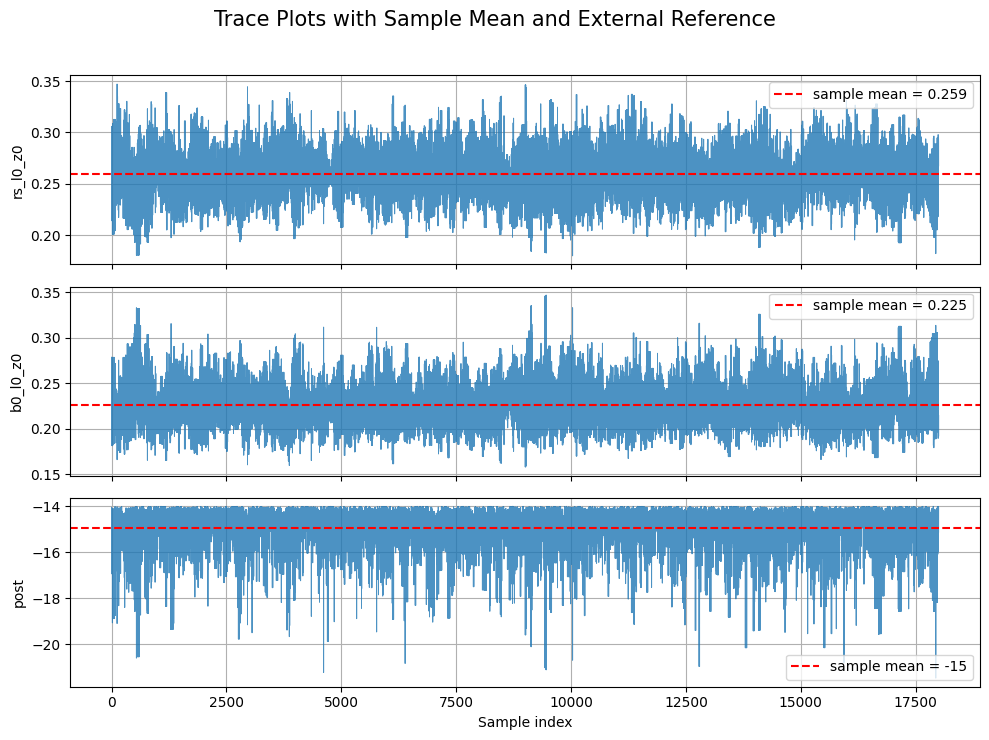

In [59]:
'''
external_means = {
    'b0_20': (0.50, 0.07),
    'rs_20': (0.37, 0.06)
}
'''
#external_means = {'rs_00': (1.37, 0.21), 'b0_00': (0.23, 0.03)}
external_means = {'rs_00': (0.44, 0.06), 'b0_00': (0.34, 0.05)}#l0z0
#
fig = plot_trace(df, burnin=0.1, external_means=external_means)
plt.show()

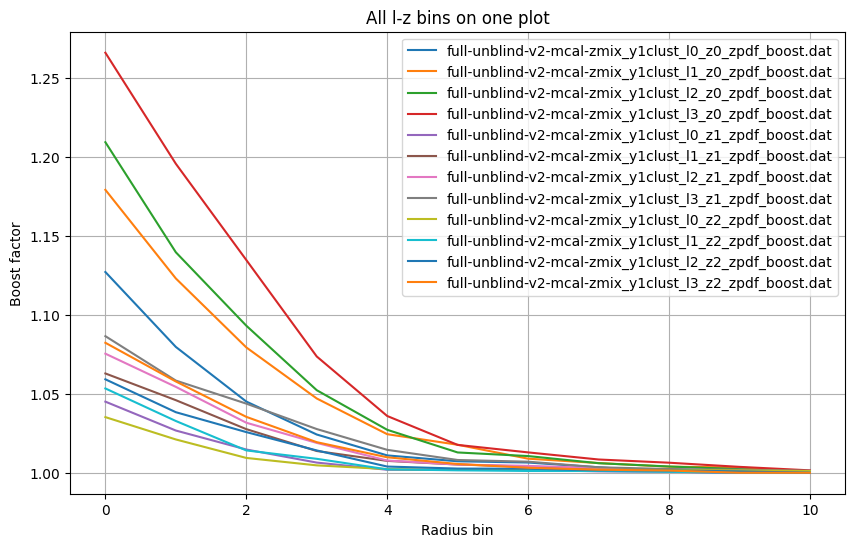

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# List of your files
files = [
    "profiles/full-unblind-v2-mcal-zmix_y1clust_l0_z0_zpdf_boost.dat",
    "profiles/full-unblind-v2-mcal-zmix_y1clust_l1_z0_zpdf_boost.dat",
    "profiles/full-unblind-v2-mcal-zmix_y1clust_l2_z0_zpdf_boost.dat",
    "profiles/full-unblind-v2-mcal-zmix_y1clust_l3_z0_zpdf_boost.dat",
    "profiles/full-unblind-v2-mcal-zmix_y1clust_l0_z1_zpdf_boost.dat",
    "profiles/full-unblind-v2-mcal-zmix_y1clust_l1_z1_zpdf_boost.dat",
    "profiles/full-unblind-v2-mcal-zmix_y1clust_l2_z1_zpdf_boost.dat",
    "profiles/full-unblind-v2-mcal-zmix_y1clust_l3_z1_zpdf_boost.dat",
    "profiles/full-unblind-v2-mcal-zmix_y1clust_l0_z2_zpdf_boost.dat",
    "profiles/full-unblind-v2-mcal-zmix_y1clust_l1_z2_zpdf_boost.dat",
    "profiles/full-unblind-v2-mcal-zmix_y1clust_l2_z2_zpdf_boost.dat",
    "profiles/full-unblind-v2-mcal-zmix_y1clust_l3_z2_zpdf_boost.dat",
    # ... add the rest of your 12 files here
]

plt.figure(figsize=(10, 6))

for f in files:
    data = np.loadtxt(f)          # load file
    x = range(11)                # first column
    y = data[:,1]                 # second column
    plt.plot(x, y, label=f.split("/")[-1])  # use filename as label

plt.xlabel("Radius bin")
plt.ylabel("Boost factor")
plt.title("All l-z bins on one plot")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
data0 = np.loadtxt("profiles/full-unblind-v2-mcal-zmix_y1clust_l0_z0_zpdf_boost.dat")

In [36]:
data0.shape


(11, 3)

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Folder with your files ---
folder = "profiles"   # adjust if needed

n_r, n_b = 11, 11  # update to match your actual bins
plt.figure(figsize=(10, 6))

for z in range(n_z):
    for l in range(n_l):
        filename = os.path.join(
            folder,
            f"full-unblind-v2-mcal-zmix_y1clust_l{l}_z{z}_zpdf_boost.dat"
        )

        # Load .dat file (assuming whitespace or tab separated)
        df = pd.read_csv(filename, delim_whitespace=True, header=None)

        # If your file has columns like: x, y, yerr
        # adjust accordingly
        df.columns = ["r", "value", "col3", "col4"][:df.shape[1]] 

        # Summary stats per radial bin
        summary = df.describe(percentiles=[0.16, 0.5, 0.84]).T
        summary = summary[["mean", "16%", "84%"]]

        r_bins = range(n_r)

        # Plot mean as line
        plt.plot(r_bins, summary["mean"], marker="o", label=f"z{z}, l{l}")

        # Optional: add shaded 68% CI band
        plt.fill_between(r_bins, summary["16%"], summary["84%"], alpha=0.15)

plt.xlabel("Radial bin index (r)")
plt.ylabel("Clustering boost")
plt.title("Boost factor across all z,l bins")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="small")
plt.tight_layout()
plt.show()


/var/folders/95/7hnb49ms3217pvkx_6925mr40000gn/T/ipykernel_11941/3072335724.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filename, delim_whitespace=True, header=None)


KeyError: "None of [Index(['mean', '16%', '84%'], dtype='object')] are in the [columns]"

<Figure size 1000x600 with 0 Axes>